# Topology of Learning in Artificial Neural Networks
This notebook accompanies the preprint https://arxiv.org/abs/1902.08160

The main goal is to monitor the evolution of neural network weights during training by representing them as a Mapper graph.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras import initializers, regularizers, optimizers
from keras.callbacks import Callback

Using TensorFlow backend.


## Import and process data

### MNIST
28*28 images of hand-written digits. 

Benchmark: 90-99%. 

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### Fashion-MINST
28*28 images of 10 classes of fashion articles:

"0-T-shirt/top","1-Trouser","2-Pullover","3-Dress","4-Coat","5-Sandal","6-Shirt","7-Sneaker","8-Bag","9-Ankle boot".

Benchmark: 90-96% (human performance: 83%).

https://github.com/zalandoresearch/fashion-mnist

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

### CIFAR-10
32*32 color images of 10 classes of objects:

"0-Airplane","1-Automobile","2-Bird","3-Cat","4-Deer","5-Dog","6-Frog","7-Horse","8-Ship","9-Truck".

Benchmark: 75-96%.

In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

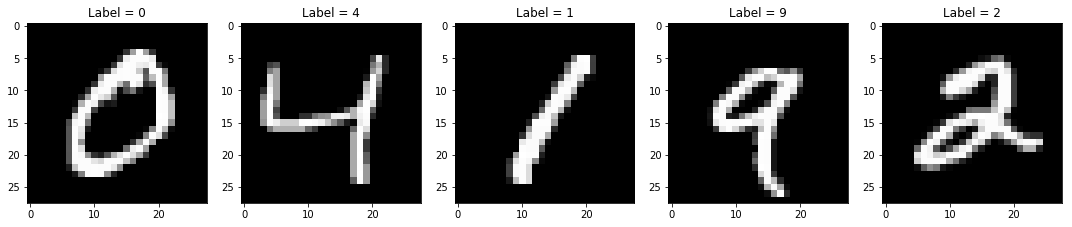

In [3]:
# Plot examples of images
fig = plt.figure(figsize=(15, 3))
rows, columns = 1, 5
for i in range(1, rows*columns +1):
    fig.add_subplot(rows, columns, i)
    img = X_train[i]
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title('Label = {}'.format(y_train[i]))
plt.tight_layout()
plt.show()

In [4]:
# Normalize
X_train, X_test = X_train / 255.0, X_test / 255.0
# Flatten images into vectors of pixels
pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape(X_train.shape[0], pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], pixels).astype('float32')
print('Train shape: {}\nTest shape: {}'.format(X_train.shape, X_test.shape))
# Encode labels as one-hot vectors
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

Train shape: (60000, 784)
Test shape: (10000, 784)


## Train neural network with multiple layers

In [5]:
def train_model(X_train, y_train, X_test, y_test,
                neurons=[pixels, 30, 10],
                init=initializers.RandomNormal(mean=0.0, stddev=0.01, seed=42),
                activation='sigmoid', l1=0.0, l2=0.0, 
                loss='categorical_crossentropy', learning_rate=0.01,
                epochs=5, batch_size=100, training_steps=500):
    
    activ = [activation]*(len(neurons)-2)+['softmax']

    model = Sequential()
    for n in range(1, len(neurons)):
        model.add(Dense(neurons[n],
                    input_dim=neurons[n-1], 
                    kernel_initializer=init,
#                     kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2),
                    use_bias=False,
                    activation=activ[n-1]))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=learning_rate, momentum=0.0, decay=0.0, nesterov=False),
                  metrics=['accuracy'])

    # Train model
    training_steps = training_steps    # Desired number of training steps (approximate)
    N_ws = round((len(X_train) * epochs) / (batch_size * training_steps))
    WSaver = SaveWeights(model, N_ws)
#     ConfSaver = SaveConfusion(model, N_ws)    # Save confusion matrix (slow)
    calback_list = [WSaver]    # [WSaver, ConfSaver]
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                        epochs=epochs, batch_size=batch_size, callbacks=calback_list, verbose=2)
    scores = model.evaluate(X_test, y_test, verbose=0)

    W_layer = {}
    for n in range(len(model.layers)):
        W_layer[n] = WSaver.weights_layer[n]
    steps = len(W_layer[0])
    # Lists of vectors of weights for each neuron for each training step
    X_layer = {}
    for n in range(len(model.layers)):
        X_layer[n] = np.squeeze([W_layer[n][i][:, [j]] for i in range(steps) for j in range(neurons[n+1])])
    # Labels = [neuron number, training step]
    y_layer = {}
    for n in range(len(model.layers)):
        y_layer[n] = np.array([[j, i] for i in range(steps) for j in range(neurons[n+1])])
    # Number of weight matrices saved = 1 + (60000 * epochs) / (batch_size * N_ws)
    print('Training steps: {}'.format(steps))

    # Plot training and validation accuracy (and loss)
    plt.figure(figsize=(15, 4))
#     plt.subplot(121)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
#     plt.subplot(122)
#     plt.plot(history.history['loss'])
#     plt.plot(history.history['val_loss'])
#     plt.title('Model loss')
#     plt.ylabel('Loss')
#     plt.xlabel('Epoch')
#     plt.legend(['Train', 'Test'], loc='upper right')
    plt.tight_layout()
    plt.show()
    
    return W_layer, X_layer, y_layer    #, ConfSaver.confusions

# Callback function to save weights after each N mini-batches
class SaveWeights(Callback):
    def __init__(self, model, N):
        self.model = model
        self.N = N
        self.batch = 0
    def on_train_begin(self, logs={}):
        self.weights_layer = {}
        for n in range(len(self.model.layers)):
            self.weights_layer[n] = [self.model.layers[n].get_weights()[0]]
    def on_batch_end(self, batch, logs={}):
        if self.batch % self.N == 0:
            for n in range(len(self.model.layers)):
                self.weights_layer[n].append(self.model.layers[n].get_weights()[0])
        self.batch += 1
        
# Callback function to save confusion matrix after each N mini-batches
# Slows down training significantly!
class SaveConfusion(Callback):
    def __init__(self, model, N):
        self.model = model
        self.N = N
        self.batch = 0
    def on_train_begin(self, logs={}):
        y_pred = self.model.predict(X_test)
        self.confusions = [confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))]
    def on_batch_end(self, batch, logs={}):
        if self.batch % self.N == 0:
            y_pred = self.model.predict(X_test)
            self.confusions.append(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
        self.batch += 1

## PCA plots in 3d

In [6]:
from sklearn.decomposition import PCA
import plotly as py
import plotly.graph_objs as go
from IPython.display import IFrame
from IPython.display import display

def PCA_3d(XX, yy, filename='PCA.html', coloring='Step', size=2, opacity=0.5):
    
    X_pca = PCA(n_components=3).fit_transform(XX)
    
    if coloring == 'Acc':
        acc = history.history['val_acc']
        d_acc = [t - s for s, t in zip(acc, acc[1:])]
        color = np.repeat(d_acc, np.ceil(len(yy)/len(d_acc)))[-len(yy):]
        color = (color-min(color))/(max(color)-min(color))    # normalize
        color = [min(x, 0.5) for x in color]    # truncate for better visibility
    elif coloring == 'Step':
        color = yy[:,1]
        
    trace = go.Scatter3d(
        x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
        mode='markers',
        text=['Neuron: {}, Step: {}'.format(yy[i,0], yy[i,1]) for i in range(len(yy))],
        marker=dict(size=2,
                    color=color, 
                    colorscale='Viridis',
                    opacity=0.8))
    fig = go.Figure(data=[trace], layout=go.Layout(margin=dict(l=0,r=0,b=0,t=0)))
    py.offline.plot(fig, filename=filename, auto_open=False)

## Mapper graphs
From the high-dimensional point clouds of weights we construct and visualize Mapper graphs using KeplerMapper.

https://github.com/MLWave/kepler-mapper

In [8]:
import kmapper as km
from sklearn.cluster import DBSCAN

# Create graph with PCA filter function
def graph_km(data, label, path, projection=PCA(3), title='Title',
                     nr_cubes=15, overlap_perc=0.5, clusterer=DBSCAN(1)):
    
    mapper = km.KeplerMapper(verbose=1)
    projected_data = mapper.fit_transform(data, projection=projection, scaler=None)
    graph = mapper.map(projected_data, data, nr_cubes=nr_cubes, overlap_perc=overlap_perc, clusterer=clusterer)      
    color = label[:,1]
    html = mapper.visualize(graph,
                            path_html=path,
                            title=title,
                            custom_tooltips=label,
                            color_function=color)

## Experimentations

Train on 60000 samples, validate on 10000 samples
Epoch 1/70
 - 1s - loss: 2.3040 - acc: 0.1088 - val_loss: 2.3057 - val_acc: 0.1135
Epoch 2/70
 - 1s - loss: 2.3041 - acc: 0.1060 - val_loss: 2.3037 - val_acc: 0.1032
Epoch 3/70
 - 1s - loss: 2.3044 - acc: 0.1069 - val_loss: 2.3040 - val_acc: 0.1135
Epoch 4/70
 - 1s - loss: 2.3040 - acc: 0.1078 - val_loss: 2.3036 - val_acc: 0.1135
Epoch 5/70
 - 1s - loss: 2.3039 - acc: 0.1069 - val_loss: 2.3025 - val_acc: 0.1135
Epoch 6/70
 - 1s - loss: 2.3039 - acc: 0.1053 - val_loss: 2.3031 - val_acc: 0.1135
Epoch 7/70
 - 1s - loss: 2.3039 - acc: 0.1056 - val_loss: 2.3028 - val_acc: 0.1135
Epoch 8/70
 - 1s - loss: 2.3038 - acc: 0.1044 - val_loss: 2.3020 - val_acc: 0.1135
Epoch 9/70
 - 1s - loss: 2.3035 - acc: 0.1077 - val_loss: 2.3026 - val_acc: 0.1135
Epoch 10/70
 - 1s - loss: 2.3036 - acc: 0.1075 - val_loss: 2.3056 - val_acc: 0.1010
Epoch 11/70
 - 1s - loss: 2.3033 - acc: 0.1062 - val_loss: 2.3039 - val_acc: 0.1135
Epoch 12/70
 - 1s - loss: 2.3036 - 

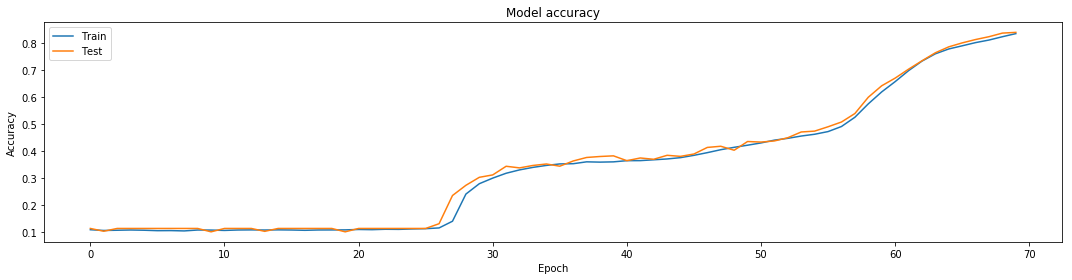

In [18]:
# Initialize weights
init = initializers.RandomNormal(mean=0.0, stddev=0.000001, seed=42)

# Architecture of the neural network
neurons = [pixels, 100, 100, 10]

# Train 
W_layer, X_layer, y_layer = train_model(X_train, y_train, X_test, y_test,
                                        neurons=neurons,
                                        init=init,
                                        activation='sigmoid',
                                        loss='categorical_crossentropy',
                                        l1=0.0, l2=0.0, 
                                        learning_rate=0.05,
                                        epochs=70, 
                                        batch_size=100,
                                        training_steps=200)

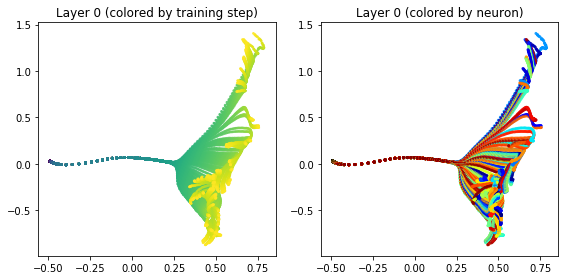

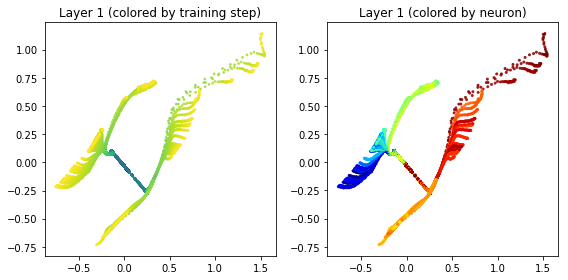

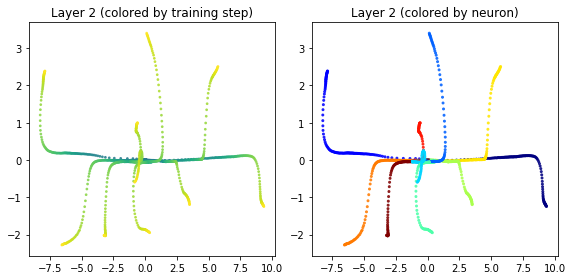

In [19]:
# 2d PCA plots
for lay_num in range(len(X_layer)):
    X_pca2 = PCA(n_components=2).fit_transform(X_layer[lay_num])
    plt.figure(figsize=(8,4))
    plt.subplot(121)
    plt.scatter(X_pca2[:,0], X_pca2[:,1], s=3, c=y_layer[lay_num][:,1], cmap = plt.cm.get_cmap('viridis'), alpha=.8)
    plt.title('Layer {} (colored by training step)'.format(lay_num))
    plt.subplot(122)
    plt.scatter(X_pca2[:,0], X_pca2[:,1], s=4, c=y_layer[lay_num][:,0], cmap = plt.cm.get_cmap('jet'), alpha=.8)
    plt.title('Layer {} (colored by neuron)'.format(lay_num))
    plt.tight_layout()
    plt.show()

In [20]:
# 3d PCA plots
for lay_num in range(len(X_layer)):
    PCA_3d(X_layer[lay_num], y_layer[lay_num], coloring='Step',
             filename='PCA_{}.html'.format(lay_num), size=3, opacity=1.0)
    display(IFrame('PCA_{}.html'.format(lay_num), 1000, 400))

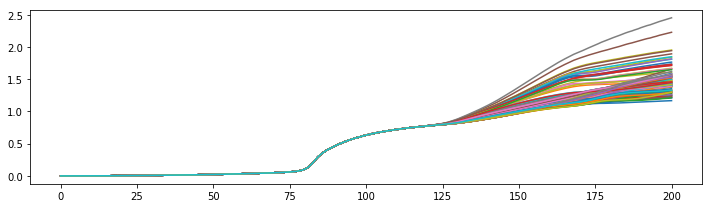

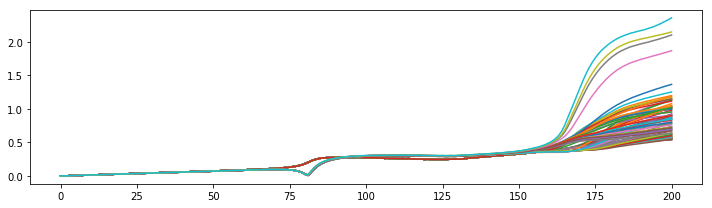

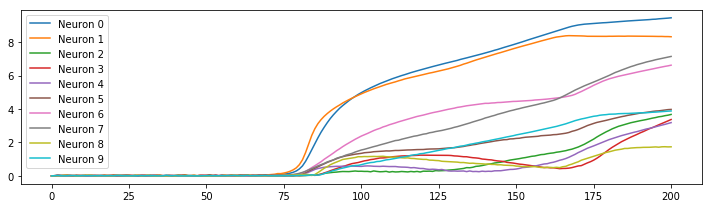

In [22]:
# Evolution of weight norms
for lay_num in range(len(X_layer)):
    fig = plt.figure(figsize=(10, 3))
    norms = {}
    steps = len(X_layer[lay_num])
    for i in range(neurons[lay_num+1]):
        norms[i] = [np.linalg.norm(X_layer[lay_num][j]) for j in range(i, steps, neurons[lay_num+1])]
        if neurons[lay_num+1] <= 10:
            plt.plot(norms[i], label='Neuron {}'.format(i))
            plt.legend()
        else:
            plt.plot(norms[i])
    plt.tight_layout()
    plt.show()

In [23]:
# Reduce with PCA first to speed up Mapper algorithm
X_reduced = {}
for lay_num in range(len(X_layer)):
    X_reduced[lay_num] = PCA(n_components=20).fit_transform(X_layer[lay_num])

In [26]:
# Learning graph for layer 0
lay_num = 0

proj = 'l2norm'    # PCA(3)
nr_cubes = 30
overlap_perc = 0.99
clusterer = DBSCAN(eps=0.1, min_samples=2)

graph_km(X_reduced[lay_num], y_layer[lay_num], 
         projection=proj, 
         title='Weights to layer {} (color by {})'.format(lay_num, color_fct),
         path='Graph_{}.html'.format(lay_num),
         nr_cubes=nr_cubes,
         overlap_perc=overlap_perc,
         clusterer=clusterer)

IPython.display.IFrame('Graph_{}.html'.format(lay_num), 800, 600)

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (20100, 20)

..Projecting data using: l2norm
Mapping on data shaped (20100, 20) using lens shaped (20100, 1)

Creating 30 hypercubes.

Created 155 edges and 156 nodes in 0:00:03.440669.
Wrote visualization to: Graph_0.html


In [35]:
# Learning graph for layer 1
lay_num = 1

proj = 'l2norm'    # PCA(3)
nr_cubes = 25
overlap_perc = 0.99
clusterer = DBSCAN(eps=0.2, min_samples=2)

graph_km(X_reduced[lay_num], y_layer[lay_num], 
         projection=proj, 
         title='Weights to layer {} (color by {})'.format(lay_num, color_fct),
         path='Graph_{}.html'.format(lay_num),
         nr_cubes=nr_cubes,
         overlap_perc=overlap_perc,
         clusterer=clusterer)

IPython.display.IFrame('Graph_{}.html'.format(lay_num), 800, 600)

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (20100, 20)

..Projecting data using: l2norm
Mapping on data shaped (20100, 20) using lens shaped (20100, 1)

Creating 25 hypercubes.

Created 64 edges and 65 nodes in 0:00:03.634140.
Wrote visualization to: Graph_1.html


In [30]:
# Learning graph for layer 2
lay_num = 2

proj = 'l2norm'    # PCA(3)
nr_cubes = 20
overlap_perc = 0.99
clusterer = DBSCAN(eps=0.5, min_samples=2)

graph_km(X_reduced[lay_num], y_layer[lay_num], 
         projection=proj, 
         title='Weights to layer {} (color by {})'.format(lay_num, color_fct),
         path='Graph_{}.html'.format(lay_num),
         nr_cubes=nr_cubes,
         overlap_perc=overlap_perc,
         clusterer=clusterer)

IPython.display.IFrame('Graph_{}.html'.format(lay_num), 800, 600)

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: l2norm
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (2010, 20)

..Projecting data using: l2norm
Mapping on data shaped (2010, 20) using lens shaped (2010, 1)

Creating 20 hypercubes.

Created 67 edges and 68 nodes in 0:00:00.086279.
Wrote visualization to: Graph_2.html


# APPENDIX

### Confusion matrix

In [38]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

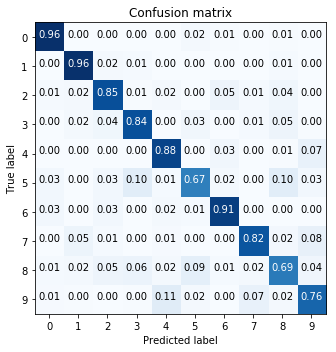

In [57]:
# Plot normalized confusion matrix
plt.figure(figsize=(15, 5))
plot_confusion_matrix(Confusions[-1], classes=range(10), normalize=True, title='Confusion matrix')
plt.show()

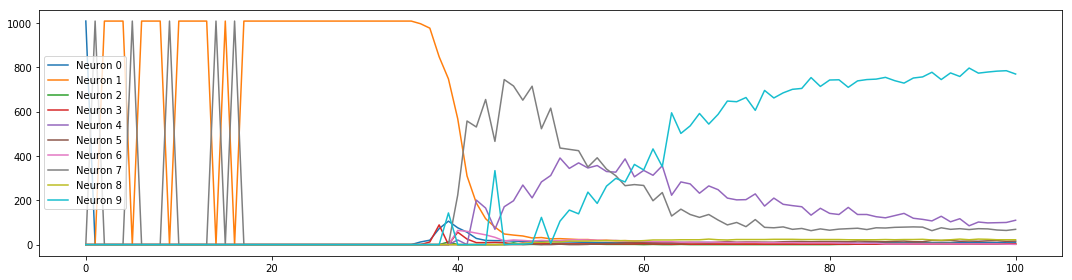

In [56]:
true_label = 9
conf_rows = {}
for i in range(10):
    conf_rows[i] = [Confusions[j][true_label][i] for j in range(len(Confusions))]
    
fig = plt.figure(figsize=(15, 4))
norms = {}
steps = len(X_layer[lay_num])
for i in range(10):
    plt.plot(conf_rows[i], label='Neuron {}'.format(i))
    plt.legend()
plt.tight_layout()
plt.show()

### Plot incoming weights to a given neuron as an image

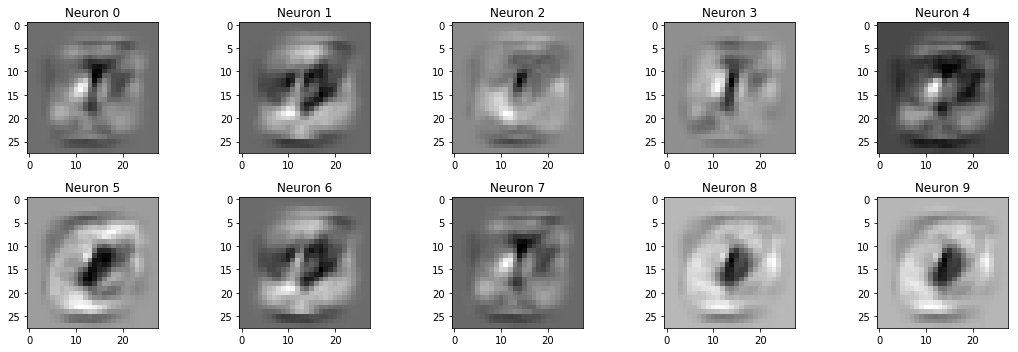

In [36]:
# Plot weights of a hidden neuron as 2d "filter"
fig = plt.figure(figsize=(15, 5))
rows, columns  = 2, 5
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    vec = W_layer[0][-1][:,i]
    vec = (vec - min(vec))/(max(vec)-min(vec))
    img = vec.reshape(28,28)    # For MNIST and Fashion-MNIST
#     img = 255 - (vec.reshape(32,32,3)*255).astype(np.uint8)    # For CIFAR-10
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.title('Neuron {}'.format(i))
plt.tight_layout()
plt.show()

### Coordinates along the learning surface

In [46]:
# Get list of neurons ordered by a PCA direction
X_pca = PCA(n_components=3).fit_transform(X_layer[0])
step = 130    # Choose a training step for which the neurons are nicely aligned along a PCA direction
dir_pca = 1    # x,y,z
ar = np.hstack((X_pca[100*step:100*(step+1)], y_layer[0][100*step:100*(step+1)]))
neuron_list = ar[ar[:,dir_pca].argsort()][:,3].astype(int)

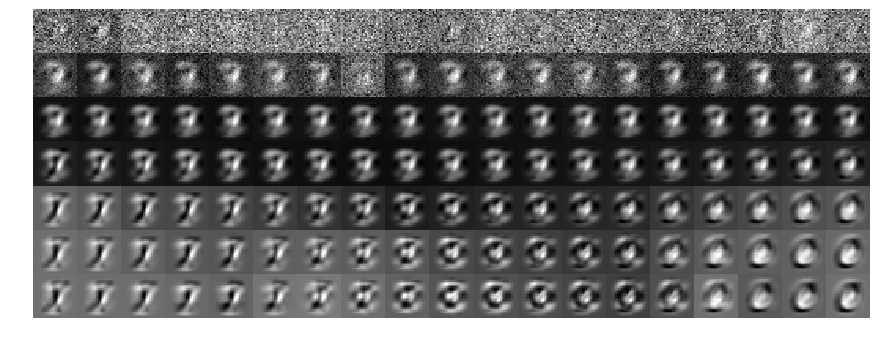

In [47]:
# Plot differences between nearby neurons (horizontally)
img_rows = ()
for step in range(100,161,10):
    imgs = ()
    skip = 5
    for i in range(skip, len(neuron_list), skip):
        img = W_layer[0][step][:,neuron_list[i-skip]] - W_layer[0][step][:,neuron_list[i]]
        img = (img - min(img))/(max(img)-min(img))
        img = img.reshape(28,28)
#         img = 255 - (img.reshape(32,32,3)*255).astype(np.uint8)    # For CIFAR-10
        imgs = imgs + (img,)
#     imgs = imgs/np.linalg.norm(imgs)    # For CIFAR-10
    img_rows = img_rows + (np.hstack(imgs),)
img_mat = np.vstack(img_rows)

fig = plt.figure(figsize=(15, 15))
plt.imshow(img_mat, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

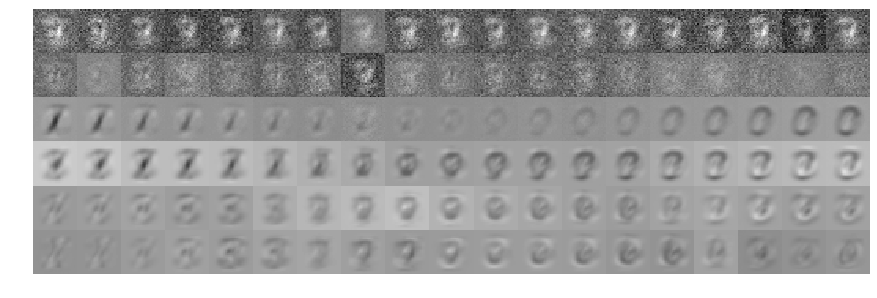

In [48]:
# Vertical differences 
rows_diff = [img_rows[i+1] - img_rows[i] for i in range(len(img_rows)-1)]
img_mat_diff = np.vstack(rows_diff)

fig = plt.figure(figsize=(15, 15))
plt.imshow(img_mat_diff, cmap=plt.get_cmap('gray'))
plt.axis('off')
plt.show()

### Animation of neuron evolution

In [49]:
%matplotlib notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


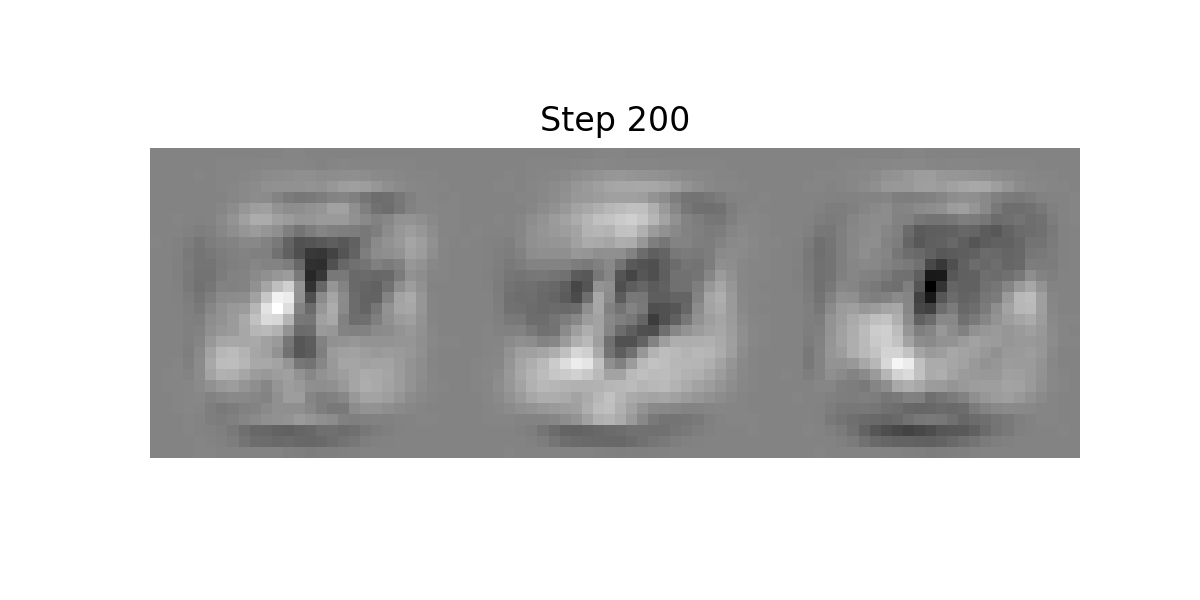

In [66]:
import matplotlib.animation as animation

fig = plt.figure(figsize=(6, 3))
    
def update(frame_number):
    N = 10 * frame_number
    img0 = W_layer[0][N][:,0].reshape(28,28)
    img1 = W_layer[0][N][:,1].reshape(28,28)
    img2 = W_layer[0][N][:,2].reshape(28,28)
    plt.imshow(np.hstack((img0, img1, img2)), cmap=plt.get_cmap('gray'))
    plt.title('Step {}'.format(N))
    plt.axis('off')

# Construct the animation
animation = animation.FuncAnimation(fig, update, frames=21, interval=500, repeat=False)

plt.show()